# Install Dependencies

In [2]:
!pip uninstall -y box2d-py
!pip install box2d


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 90.0 MB/s eta 0:00:00


# Import the Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Load pretrained CLIP model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Check if the model is loaded successfully

In [5]:
print("✅ CLIP model loaded on", device)

✅ CLIP model loaded on cuda


# Define a simple Action Projection Head

In [6]:
class ActionHead(nn.Module):
    def __init__(self, input_dim=512, action_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))  # Action space in [-1, 1]

action_head = ActionHead().to(device)

# Encode image + text → action embedding

In [7]:
def vla_infer(image_path, instruction):
    inputs = processor(text=[instruction], images=Image.open(image_path), return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    vision_emb = outputs.image_embeds
    text_emb = outputs.text_embeds
    fused_emb = F.normalize(vision_emb + text_emb, dim=-1)
    action_vec = action_head(fused_emb)
    return vision_emb, text_emb, action_vec

# Test with example input

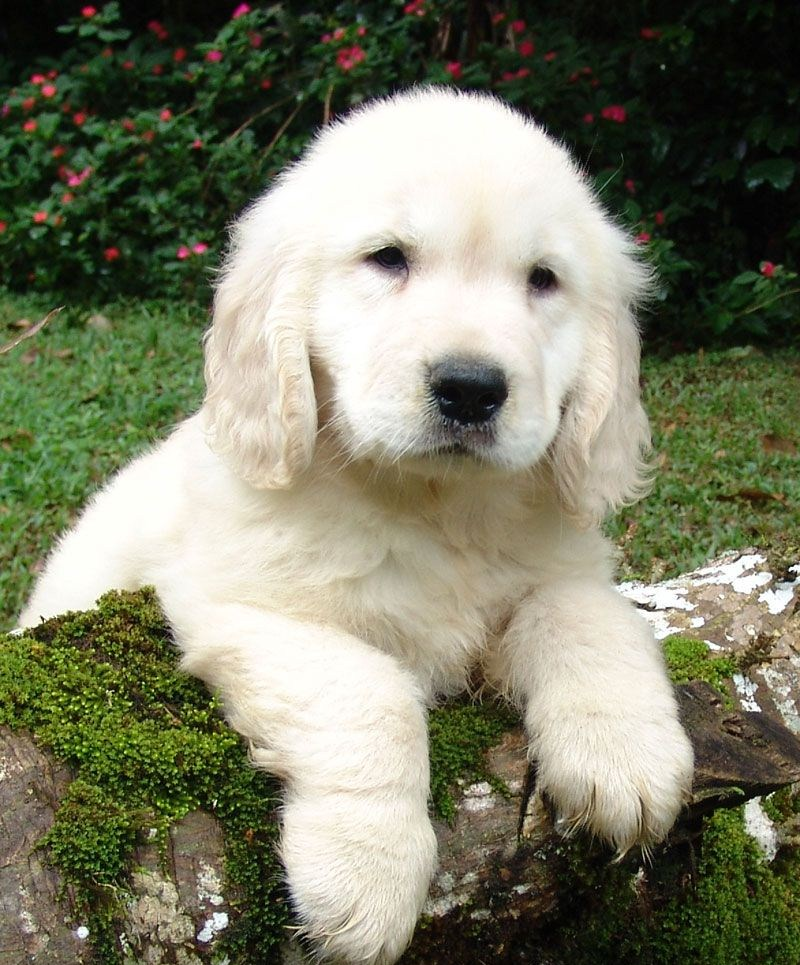


🖼️  Vision Embedding: torch.Size([1, 512])
💬  Text Embedding: torch.Size([1, 512])
⚙️  Predicted Action Vector: [[ 0.01856647 -0.02840957 -0.02259131]]


In [13]:

!wget -q https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg -O sample.jpg

instruction = "Move forward carefully towards the dog"

from PIL import Image
img = Image.open("sample.jpg")
display(img)

vision_emb, text_emb, action_vec = vla_infer("sample.jpg", instruction)

print("\n🖼️  Vision Embedding:", vision_emb.shape)
print("💬  Text Embedding:", text_emb.shape)
print("⚙️  Predicted Action Vector:", action_vec.detach().cpu().numpy())



# Visualize alignment

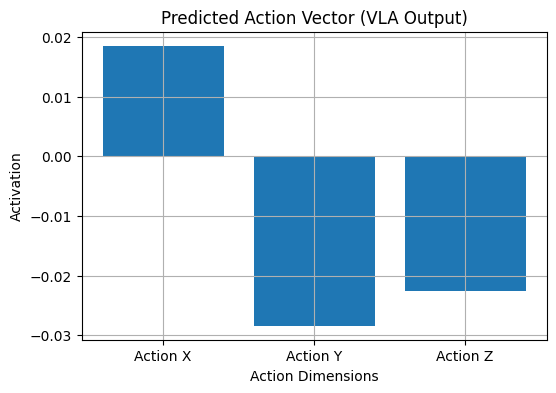

In [14]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(["Action X", "Action Y", "Action Z"], action_vec[0].detach().cpu().numpy())
plt.title("Predicted Action Vector (VLA Output)")
plt.xlabel("Action Dimensions")
plt.ylabel("Activation")
plt.grid(True)
plt.show()